<a href="https://colab.research.google.com/github/nimamt/machine_learning/blob/master/pytorch/reinforcement/NStepDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y xvfb

!pip install \
  gym[atari,accept-rom-license]==0.23.1 \
  pytorch-lightning==1.6.0 \
  stable-baselines3 \
  pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 780 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 xvfb amd64 2:1.20.13-1ubuntu1~20.04.6 [780 kB]
Fetched 780 kB in 0s (2,875 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 128126 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.20.13-1ubuntu1~20.04.6_amd64.deb ...
Unpacking xvfb (2:1.20.13-1ubuntu1~20.04.6) ...
Setting up xvfb (2:1.20.13-1ubuntu1~20.04.6) ...
Processing triggers for man-db (2.9.1-1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.d

In [2]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

In [3]:
import copy
import torch
import random
import gym
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import TransformObservation, NormalizeObservation, \
  NormalizeReward, RecordVideo, RecordEpisodeStatistics, AtariPreprocessing


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

In [5]:
import math
from torch.nn.init import kaiming_uniform_, zeros_

class NoisyLinear(nn.Module):

  def __init__(self, in_features, out_features, sigma):
    super(NoisyLinear, self).__init__()

    self.w_mu = nn.Parameter(torch.empty((out_features, in_features)))
    self.w_sigma = nn.Parameter(torch.empty((out_features, in_features)))
    self.b_mu = nn.Parameter(torch.empty((out_features)))
    self.b_sigma = nn.Parameter(torch.empty((out_features)))

    kaiming_uniform_(self.w_mu, a=math.sqrt(5))    
    kaiming_uniform_(self.w_sigma, a=math.sqrt(5)) 
    zeros_(self.b_mu)
    zeros_(self.b_sigma)

  def forward(self, x, sigma=0.5):
    # Bigger sigma - More spread around - More noise
    
    if self.training:
      w_noise = torch.normal(0, sigma, size=self.w_mu.size()).to(device)
      b_noise = torch.normal(0, sigma, size=self.b_mu.size()).to(device)
      return F.linear(x, self.w_mu + self.w_sigma * w_noise, 
                    self.b_mu + self.b_sigma * b_noise)
    else:
      return F.linear(x, self.w_mu, self.b_mu)

In [6]:
class DQN(nn.Module):

  def __init__(self, hidden_size, obs_shape, n_actions, sigma=0.5):
    super().__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(obs_shape[0], 64, kernel_size=3),
        nn.MaxPool2d(kernel_size=4),
        nn.ReLU(),
        nn.Conv2d(64, 16, kernel_size=3),
        nn.MaxPool2d(kernel_size=4),
        nn.ReLU(),
    )

    conv_out_size = self._get_conv_out(obs_shape)
    self.head = nn.Sequential(
        NoisyLinear(conv_out_size, hidden_size, sigma=sigma),
        nn.ReLU(),
        NoisyLinear(hidden_size, hidden_size, sigma=sigma),
        nn.ReLU(),
    )

    # Q(s, a) = V(s) + Adv(s, a)
    self.fc_value = NoisyLinear(hidden_size, 1, sigma=sigma)
    self.fc_adv = NoisyLinear(hidden_size, n_actions, sigma=sigma)

  def _get_conv_out(self, shape):
    conv_out = self.conv(torch.zeros(1, *shape))
    return int(np.prod(conv_out.size()))

  def forward(self, x):
    x = self.conv(x.float()).view(x.size()[0], -1) # First arg is batch_size
    x = self.head(x)
    adv = self.fc_adv(x)
    value = self.fc_value(x)
    return value + adv - torch.mean(adv, dim=1, keepdim=True)

In [28]:
def greedy(state, net):
  state = torch.tensor([state]).to(device)
  q_values = net(state)
  action = q_values.argmax(dim=-1)
  action = int(action.item())
  return action

In [7]:
class ReplayBuffer: 

  def __init__(self, capacity):
    super().__init__()
    self.buffer = deque(maxlen=capacity) # Will automatically delete old entries
    # to make room for new ones

    # stores priorites of each of the samples contained in the buffer
    self.priorities = deque(maxlen=capacity)

    self.capacity = capacity

    self.alpha = 1.0
    self.beta = 0.5
    self.max_priority = 0.0

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)
    self.priorities.append(self.max_priority)

  def update(self, index, priority):
    if priority > self.max_priority:
      self.max_priority = priority
    self.priorities[index] = priority 
  def sample(self, batch_size):
    probs = np.array(self.priorities, dtype=np.float64) + 1e-4
    probs = probs ** self.alpha
    probs = probs / probs.sum()

    weights = (self.__len__() * probs) ** -self.beta
    weights = weights / weights.max()

    idx = random.choices(range(self.__len__()), weights=probs, k=batch_size)
    sample = [(i, weights[i], *self.buffer[i]) for i in idx]    
    return sample

In [8]:
class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=200):
    self.buffer = buffer
    self.sample_size = sample_size

  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

In [9]:
env = gym.make('PongNoFrameskip-v4')

In [10]:
env.observation_space, env.action_space

(Box(0, 255, (210, 160, 3), uint8), Discrete(6))

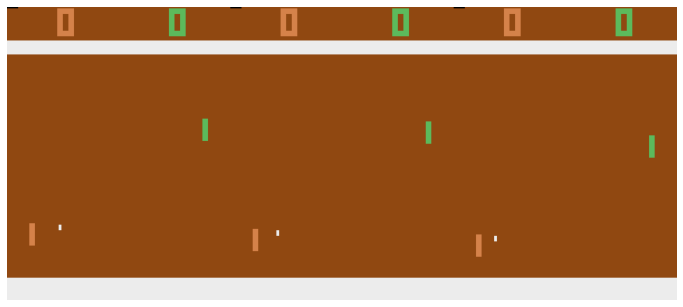

In [15]:
frames = []
i = 100
skip = 4
obs = env.reset()
done = False

while not done:
  frames.append(obs)
  obs, _, done, _ = env.step(env.action_space.sample())

img = np.hstack([frames[i], frames[i+skip], frames[i+2*skip]])
plt.figure(figsize=(12, 8))
plt.axis("off")
plt.imshow(img)

In [16]:
env = AtariPreprocessing(env, frame_skip=8, screen_size=42)

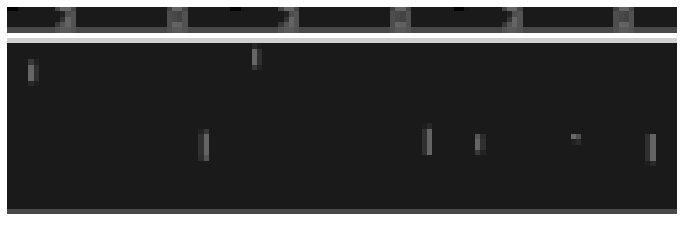

In [19]:
frames = []
i = 100
skip = 1
obs = env.reset()
done = False

while not done:
  frames.append(obs)
  obs, _, done, _ = env.step(env.action_space.sample())

img = np.hstack([frames[i], frames[i+skip], frames[i+2*skip]])
plt.figure(figsize=(12, 8))
plt.axis("off")
plt.imshow(img, cmap='gray')

In [23]:
def create_environment(name):
  env = gym.make(name)
  env = RecordVideo(env, 'videos', episode_trigger=lambda e: e % 100 == 0)
  env = RecordEpisodeStatistics(env)
  env = AtariPreprocessing(env, frame_skip=8, screen_size=42)
  env = TransformObservation(env, lambda x: x[np.newaxis, :, :])
  env.observation_space = gym.spaces.Box(low=0, high=255, shape=(1, 42, 42), dtype=np.float32)
  env = NormalizeObservation(env)
  env = NormalizeReward(env)
  return env

In [24]:
env = create_environment('PongNoFrameskip-v4')

for episode in range(10):
  done = False
  env.reset()
  while not done:
    _, _, done, _ = env.step(env.action_space.sample())

/usr/local/lib/python3.8/dist-packages/gym/wrappers/record_video.py:41: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [26]:
# display_video(episode= 0)

In [30]:
class DeepQLearning(LightningModule):

  def __init__(self, env_name, policy=greedy, capacity=100_000, 
               batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99, 
               loss_fn=F.smooth_l1_loss, optim=AdamW, samples_per_epoch=10_000, 
               sync_rate=10, a_start=0.5, a_end=0.0, a_last_episode=100,
               b_start=0.4, b_end=1.0, b_last_episode=100, sigma=0.5, n_steps=3):
    
    super().__init__()
    self.env = create_environment(env_name)

    obs_size = self.env.observation_space.shape
    n_actions = self.env.action_space.n

    self.q_net = DQN(hidden_size, obs_size, n_actions, sigma)

    # A copy that will be used to compute stable targets
    # Will update the values in this copy every sync_rate epochs
    self.target_q_net = copy.deepcopy(self.q_net) 

    self.policy = policy
    self.buffer = ReplayBuffer(capacity=capacity)

    self.save_hyperparameters()

    while len(self.buffer) < self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in experience buffer. Filling...")
      self.play_episode()

  @torch.no_grad() # We have a policy
  # If we dont include this, action will participate in the learning process
  def play_episode(self, policy=None):
    state = self.env.reset()
    done = False
    transitions = []

    while not done:
      if policy:
        action = policy(state, self.q_net)
      else:
        action = self.env.action_space.sample()
      next_state, reward, done, info = self.env.step(action)
      exp = (state, action, reward, done, next_state)
      self.buffer.append(exp)
      state = next_state

    for i, (s, a, r, d, ns) in enumerate(transitions):
      batch = transitions[i:i + self.hparams.n_steps]
      # r + gamma * r2 + gamma^2 + r3 + ...
      ret = sum([t[2] * self.hparams.gamma**j for j, t in enumerate(batch)])
      # l stands for last
      _, _, _, ld, ls = batch[-1]
      self.buffer.append((s, a, ret, ld, ls))

  def forward(self, x):
    return self.q_net(x)

  def configure_optimizers(self):
    q_net_optimizer = self.hparams.optim(self.q_net.parameters(), 
                                         lr=self.hparams.lr)
    return [q_net_optimizer] # We might have multiple neural networks, hence
                             # multiple optimizers

  def train_dataloader(self):
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=self.hparams.batch_size
    )
    return dataloader

  def training_step(self, batch, batch_idx):
    indices, weights, states, actions, returns, dones, next_states = batch
    weights = weights.unsqueeze(1)
    actions = actions.unsqueeze(1)
    returns = returns.unsqueeze(1)
    dones = dones.unsqueeze(1)

    # Gather on the first dimension, the values of the actions taken
    state_action_values = self.q_net(states).gather(1, actions)

    # DELETED
    #next_action_values, _ = self.target_q_net(next_states).max(dim=1,
    #                                                           keepdim=True)
    # DELETED
    
    # ADDED
    with torch.no_grad():
      # Selects the action to be taken
      _, next_actions = self.q_net(next_states).max(dim=1, keepdim=True)
      # Estimates the value of those actions
      next_action_values = self.target_q_net(next_states).gather(1, next_actions)
      # ADDED
      
      # It will give estimated by default (the real result is 0.0, and we know this)
      next_action_values[dones] = 0.0 

    expected_state_action_values = returns + self.hparams.gamma**self.hparams.n_steps * next_action_values

    # Compute the priorities and update
    td_errors = (state_action_values - expected_state_action_values).abs().detach()

    for idx, e in zip(indices, td_errors):
      self.buffer.update(idx, e.cpu().item())

    # Compute the weighted loss function
    # reduction = 'none' because the shape of weights is (batch_size, 1)
    loss = weights * self.hparams.loss_fn(state_action_values, expected_state_action_values, reduction='none')
    loss = loss.mean()

    self.log('episode/Q-error', loss)
    return loss

  def training_epoch_end(self, outputs):
    # Decreasing as we go forward    
    alpha = max(
        self.hparams.a_end,
        self.hparams.a_start - self.current_epoch / self.hparams.a_last_episode
    )
    beta = max(
        self.hparams.b_end,
        self.hparams.b_start - self.current_epoch / self.hparams.b_last_episode
    )
    self.buffer.alpha = alpha
    self.buffer.beta = beta

    self.play_episode(policy=self.policy)
    # RecordStatistics keeps data in return_queue
    self.log('episode/Return', self.env.return_queue[-1])

    # The targets would be more stable after this
    if self.current_epoch % self.hparams.sync_rate == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())

In [33]:
# %load_ext tensorboard
# %tensorboard --logdir /content/lightning_logs/

In [34]:
algo = DeepQLearning(
    'PongNoFrameskip-v4',
    lr=5e-4,
    hidden_size=512,
    sigma=0.5,
    samples_per_epoch=10_000,
    a_last_episode=1_000,
    b_last_episode=1_000)

trainer = Trainer(
    gpus=num_gpus,
    max_epochs=1_200,
    log_every_n_steps=1
)

trainer.fit(algo)

/usr/local/lib/python3.8/dist-packages/gym/wrappers/record_video.py:41: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


0 samples in experience buffer. Filling...
487 samples in experience buffer. Filling...
910 samples in experience buffer. Filling...
1378 samples in experience buffer. Filling...
1902 samples in experience buffer. Filling...
2297 samples in experience buffer. Filling...
2721 samples in experience buffer. Filling...
3216 samples in experience buffer. Filling...
3686 samples in experience buffer. Filling...
4275 samples in experience buffer. Filling...
4760 samples in experience buffer. Filling...
5226 samples in experience buffer. Filling...
5677 samples in experience buffer. Filling...
6238 samples in experience buffer. Filling...
6746 samples in experience buffer. Filling...
7186 samples in experience buffer. Filling...
7637 samples in experience buffer. Filling...
8109 samples in experience buffer. Filling...
8581 samples in experience buffer. Filling...
8961 samples in experience buffer. Filling...
9596 samples in experience buffer. Filling...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type | Params
--------------------------------------
0 | q_net        | DQN  | 608 K 
1 | target_q_net | DQN  | 608 K 
--------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.871     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:727: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
display(episode=200)